# Portfolio Optimization




In [68]:
#Import required libraries
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize 

# Section 1: Define Tickers and Time Range


In [69]:
# defind lists of tickets
tickers =  ['DBC','BCD', 'FTGC','USCI', 'SDCI', 'UTES', 'PXE', 'IAU', 'GLD', 'COM']  

In [70]:
#Set the end data to today
end_date = datetime.today()


In [71]:
#Set the end date to 5 years ago (the result might change be on the time frame)
start_date = end_date - timedelta(days = 5*365)
print (start_date)

2020-01-14 15:32:52.365151


# Section 2: Download Adjusted Close Prices

In [72]:
#Create an empty DataFrame to store the adjusted close prices
adj_close_df = pd.DataFrame()

In [73]:
# Dowload the close prices for each ticker
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Data Frame

In [74]:
print ( adj_close_df)

                  DBC        BCD       FTGC       USCI       SDCI       UTES  \
Date                                                                           
2020-01-14  14.228878  19.442595  14.917447  36.279999  10.079644  37.190666   
2020-01-15  14.156924  19.385176  14.949134  36.340000  10.089730  37.709587   
2020-01-16  14.138935  19.285488  14.838223  36.110001  10.034808  37.913544   
2020-01-17  14.183907  19.346098  14.893681  36.340000  10.091413  38.088619   
2020-01-21  14.102959  19.215309  14.798613  35.950001   9.998378  38.309719   
...               ...        ...        ...        ...        ...        ...   
2025-01-03  21.480000  31.250000  23.950001  66.480003  19.600000  66.709999   
2025-01-06  21.520000  31.480000  24.049999  66.760002  19.645000  66.470001   
2025-01-07  21.620001  31.610001  24.090000  67.129997  19.799999  66.110001   
2025-01-08  21.580000  31.629999  24.120001  67.230003  19.799999  66.010002   
2025-01-10  22.160000  32.419998  24.719

# Section 3: Calculate Lognormal Returns

In [75]:
# calculate the lognormal returns for each ticker
log_returns = np.log ( adj_close_df / adj_close_df.shift(1))

In [76]:
# Drop any missing values
log_returns = log_returns.dropna()

# Section 4: Calculate Covariance Matrix

 Calculate the covariance matrix using annualized log returns 

In [77]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

           DBC       BCD      FTGC      USCI      SDCI      UTES       PXE  \
DBC   0.040524  0.027793  0.029612  0.032098  0.030839  0.011457  0.056377   
BCD   0.027793  0.024510  0.023305  0.025534  0.024105  0.008731  0.036085   
FTGC  0.029612  0.023305  0.030159  0.028064  0.026628  0.010557  0.040838   
USCI  0.032098  0.025534  0.028064  0.035638  0.033158  0.011411  0.042410   
SDCI  0.030839  0.024105  0.026628  0.033158  0.035767  0.010253  0.040634   
UTES  0.011457  0.008731  0.010557  0.011411  0.010253  0.052198  0.033832   
PXE   0.056377  0.036085  0.040838  0.042410  0.040634  0.033832  0.194574   
IAU   0.009942  0.010656  0.010024  0.011533  0.010983  0.007747  0.004424   
GLD   0.009911  0.010662  0.010016  0.011521  0.010982  0.007816  0.004134   
COM   0.014127  0.011399  0.012319  0.013231  0.012961  0.003443  0.016017   

           IAU       GLD       COM  
DBC   0.009942  0.009911  0.014127  
BCD   0.010656  0.010662  0.011399  
FTGC  0.010024  0.010016  0.01

# Section 5: Define Portfolio Performance Metrics
 Calculate the portfolio standard deviation

In [78]:
#calculate the portfolio variance, which is measure of the risk associated with a portfolio of assets 
#represents the combined volality of the assets in the portfolio, taking into account their individual volatilities and correlations
def standard_deviation (weights, cov_matrix):
        variance = weights.T @ cov_matrix @ weights
        return np.sqrt(variance)

 Calculate the expected return

In [79]:
#expected return are based on historical returns 
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

 Calculate the Sharpe Raito

In [80]:

def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
        return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

# Section 6: Portfolio Optimization

Set the risk-free rate from the Fred Website 

In [81]:
risk_free_rate = 0.02

In [82]:
from fredapi import Fred 

fred = Fred(api_key='d0637da1c78b68a3477429f8b63e9189')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.043899999999999995


 Define the function to minimize (negative Sharpe Raito)

In [83]:

def neg_sharpe_raito(weights, log_returns, cov_matrix, risk_free_rate):
    return -(expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

set the constraints and bounds


In [84]:
# The constraints is the sum of portfolio = 1)
# Bonds are the limits placed on the variables during the optimization process. In this case, the variables are the portfolio weights, and each weight is around 0 to 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]


set the intial weights 

In [85]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


 Optimize the weights to maximize Sharpe Raito

In [86]:
optimized_results = minimize(neg_sharpe_raito, 
                             initial_weights, 
                             args=(log_returns, cov_matrix, risk_free_rate), 
                             method='SLSQP', 
                             constraints=constraints, 
                             bounds=bounds)

In [87]:
optimal_weights = optimized_results.x

# Section 7: Analyze the Optimal Portfolio

Dispay analytics of the portfolio

In [88]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
DBC: 0.0000
BCD: 0.0000
FTGC: 0.0000
USCI: 0.0000
SDCI: 0.2913
UTES: 0.1666
PXE: 0.0000
IAU: 0.2540
GLD: 0.0000
COM: 0.2881
Expected Annual Return: 0.1140
Expected Volatility: 0.1168
Sharpe Ratio: 0.5997


Display the portfolio in plot

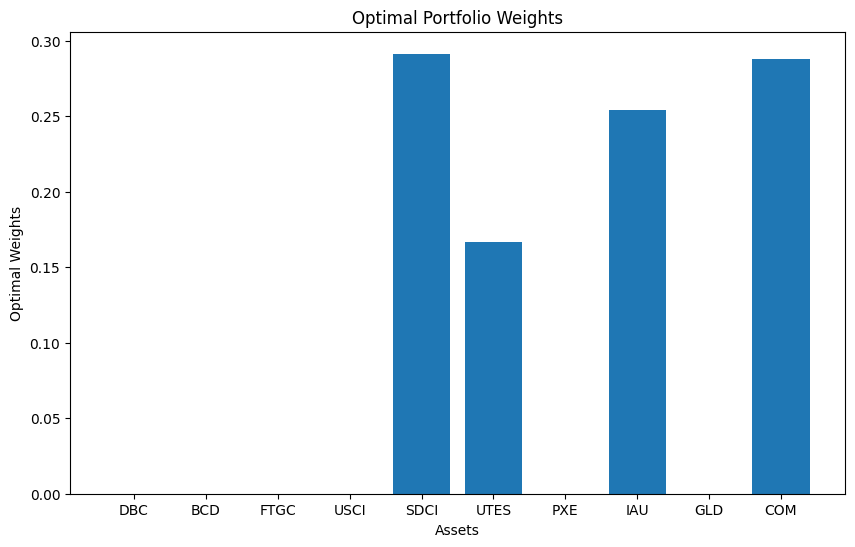

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()